In [59]:
import ads
import numpy as np
import json
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from datetime import datetime
import scipy
from scipy import stats, optimize
import pandas as pd
import glob
import pickle

%matplotlib inline

In [89]:
def double_gaussian(x, height1, loc1, scale1, height2, loc2, scale2):
    return stats.norm(loc=loc1, scale=scale1).cdf(x)*height1 +\
        stats.norm(loc=loc2, scale=scale2).cdf(x)*height2

def double_gaussian_pdf(x, height1, loc1, scale1, height2, loc2, scale2):
    return stats.norm(loc=loc1, scale=scale1).pdf(x)*height1 +\
        stats.norm(loc=loc2, scale=scale2).pdf(x)*height2

In [90]:
def double_skewnorm(x, a1, height1, loc1, scale1, a2, height2, loc2, scale2):
    return stats.skewnorm(a1, loc=loc1, scale=scale1).cdf(x)*height1 +\
        stats.skewnorm(a2, loc=loc2, scale=scale2).cdf(x)*height2

def double_skewnorm_pdf(x, a1, height1, loc1, scale1, a2, height2, loc2, scale2):
    return stats.skewnorm(a1, loc=loc1, scale=scale1).pdf(x)*height1 +\
        stats.skewnorm(a2, loc=loc2, scale=scale2).pdf(x)*height2


In [100]:
def measure_rsquared(model, data):
    SSres = sum((data - model)**2)
    SStot = sum((data - np.mean(data))**2)
    
    return 1 - (SSres / SStot)


In [3]:
journals = ['Astronomy and Astrophysics',
        "Astronomical Journal",
        "The Astrophysical Journal",
        "Monthly Notices of the Royal Astronomical Society"]


In [4]:
with open('/Users/spardy/.config/OAUTHS/ADS.json') as f:
    TOKEN = json.load(f)['TOKEN']
    
ads.config.token = TOKEN

In [10]:
paper_store = defaultdict(list)

for year in range(2000, 2005):
    year = str(year)
    for journal in journals:

        papers = ads.SearchQuery(q="pub:\"{journal}\" year:{year}".format(journal=journal, year=year),
                                 fl=['id', 'pubdate', 'property','title', 'citation',
                                     'keyword'], max_pages=20, rows=1000)
        try:
            for paper in papers:
                if 'REFEREED' not in paper.property:
                    continue
                
                if paper.keyword is None:
                    continue

                title = paper.title
                pubdate = paper.pubdate
                citations = paper.citation
                paper_store[pubdate].append({'id': paper.id, 'title':title,
                                             'citations': citations})
        except IndexError as e:
            print(e)
            pass


In [32]:
cumulative_citations = []
citations_pdf = []
citations = []
years = []

for journal in ['AA', 'MNRAS', 'ApJ', 'AJ']:
    for filename in glob.glob('/Users/spardy/Data/{:s}_papers/*.pl'.format(journal)):
        with open(filename, 'rb') as pf:
            papers = pickle.load(pf)
            for paper in papers:
                if paper['citations'] is None:
                    continue 
                if len(paper['citations']) < 5:
                    continue

                cites = np.fromiter(map(lambda c: int(c[:4]), paper['citations']), dtype=int)
                Bins = np.arange(min(cites), 2018)
                ncites, bins = np.histogram(cites, bins=Bins)
                citations_pdf.append(ncites)
                citations.append(cites)
                cumulative_citations.append(np.cumsum(ncites))
                years.append(bins)


## Plot a few distributions

In [79]:
Npapers = len(cumulative_citations)

In [80]:
nplots = 50
random_inds = np.random.choice(range(Npapers), size=nplots)

In [101]:
params = []

for i, ind in enumerate(random_inds):    
    size = len(citations[ind])
    param_dict = {}
    for distname, dist in zip(['skewnorm', 'powerlaw', '2-gaussians'],
                              [stats.skewnorm, stats.powerlaw, double_gaussian]):
    
        param_dict[distname] = {}
        if distname == '2-gaussians':
            try:
                popt, pcov = optimize.curve_fit(double_gaussian, years[ind][1:],
                                cumulative_citations[ind], p0=(1, 2000, 1, 1, 2000, 1))
                if np.any(pcov == np.inf):
                    continue
                cdf_fitted = double_gaussian(years[ind][1:], *popt)
                param_dict[distname]['params'] = popt
                
            except RuntimeError:
                continue
        else:
            param = dist.fit(citations[ind])
            cdf_fitted = dist.cdf(years[ind][1:], *param[:-2], loc=param[-2], scale=param[-1])*size
            param_dict[distname]['params'] = param
            
        rsqrd = measure_rsquared(cdf_fitted, cumulative_citations[ind])
        param_dict[distname]['rsqrd'] = rsqrd
        
    params.append(param_dict)    


/Users/spardy/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1612: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))
/Users/spardy/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [110]:
list(map(lambda x: max(x.items(), key=lambda kv: kv[1]['rsqrd'] if 'rsqrd' in kv[1] else 0), params))

[('2-gaussians',
  {'params': array([  6.80954308e+00,   1.99734597e+03,   6.02815304e-01,
            8.08895419e+00,   1.98793492e+03,   3.17786859e+00]),
   'rsqrd': 0.99002994414494727}),
 ('2-gaussians',
  {'params': array([  2.96120722e+00,   2.00133321e+03,   3.09328260e+00,
            2.06358479e+00,   2.00105836e+03,   1.19911920e-01]),
   'rsqrd': 0.98169918182556593}),
 ('2-gaussians',
  {'params': array([  5.14617256e+00,   2.00655159e+03,   6.27978023e-01,
            2.32791619e+01,   2.00236670e+03,   3.42460848e+00]),
   'rsqrd': 0.99752919985357935}),
 ('2-gaussians',
  {'params': array([  1.89531892e+01,   2.00752655e+03,   7.05159071e+00,
            1.45665091e+01,   2.00024932e+03,   1.58800612e+00]),
   'rsqrd': 0.9912110580941943}),
 ('2-gaussians',
  {'params': array([  194.77288356,  2019.09822054,     6.82655019,    68.73584299,
           2005.2685713 ,     2.65616178]),
   'rsqrd': 0.99511943449406948}),
 ('2-gaussians',
  {'params': array([  2.90203908e+01

In [116]:
cumulative_citations[ind]

array([3, 3, 3, 3, 3, 4, 4, 5])

In [117]:
param = params_['skewnorm']['params']
cdf_fitted = stats.powerlaw.cdf(years[ind][1:], *param[:-2], loc=param[-2], scale=param[-1])*size


In [119]:
measure_rsquared(cdf_fitted, cumulative_citations[ind])

-8.25

In [115]:
params_

{'2-gaussians': {},
 'powerlaw': {'params': (1.2102806958182812,
   2007.8775209581715,
   8.1224790424038567),
  'rsqrd': -1.0326488933964972},
 'skewnorm': {'params': (9292214.6605320293,
   2008.9999978741771,
   3.8471536164923581),
  'rsqrd': -0.72880246812840577}}

In [124]:
colors = {'2-gaussians': '#66c2a5', 'powerlaw': '#fc8d62', 'skewnorm': '#8da0cb'}

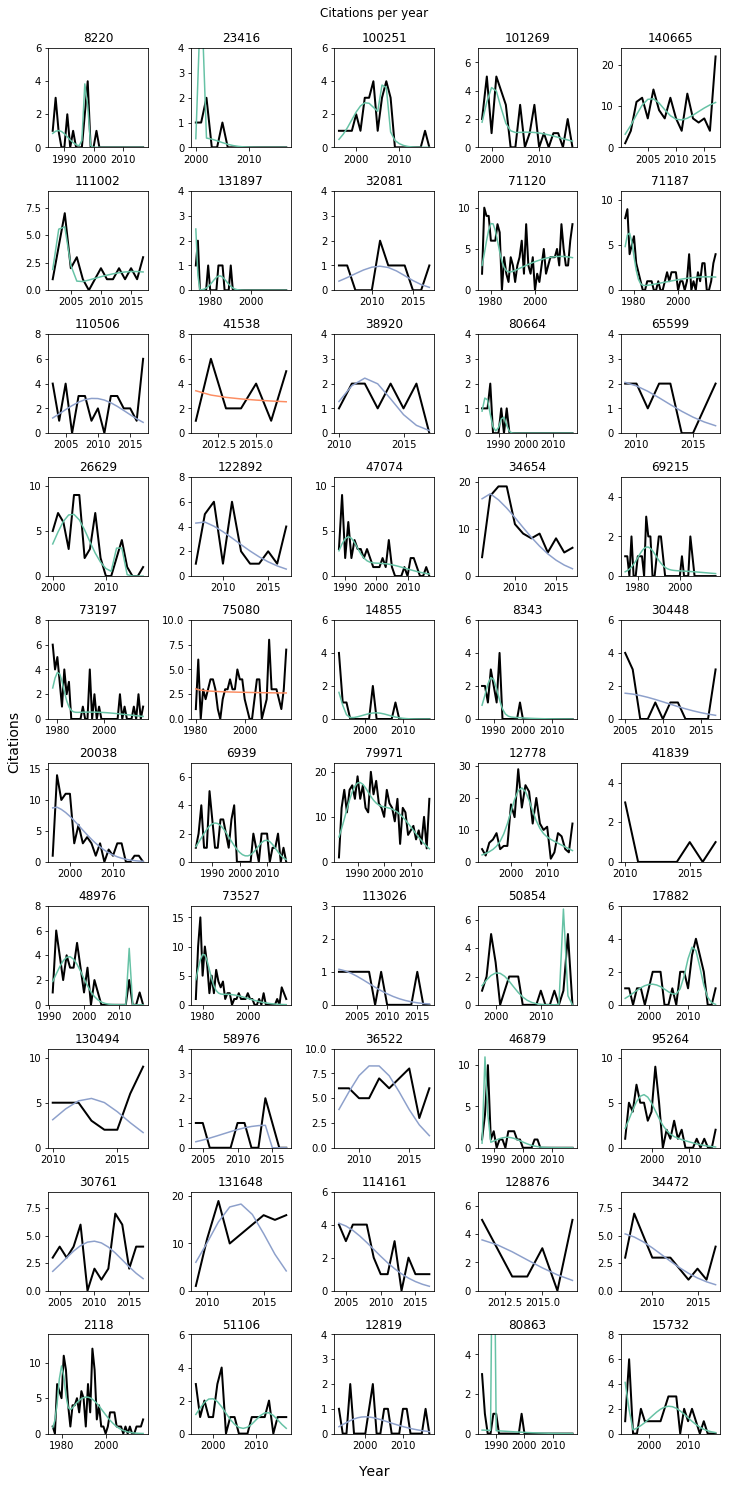

In [125]:
ncols = 5
nrows = int(np.ceil(nplots / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2))
axes = axes.flatten()
for i, ind in enumerate(random_inds):
    axis = axes[i]
    
    axis.plot(years[ind][1:], citations_pdf[ind], color='black', linewidth=2)
    maxy = max(citations_pdf[ind])
    size = len(citations[ind])
    axis.set_ylim(0, maxy+2)
    axis.set_title(str(ind))
    
    try:
        params_ = params[i]
        best_fit = max(params_.items(), key=lambda kv: kv[1]['rsqrd'] if 'rsqrd' in kv[1] else 0)
        distname = best_fit[0]
        best_params = best_fit[1]['params']
    except KeyError:
         continue

    if distname == '2-gaussians':
        axis.plot(years[ind][1:], double_gaussian_pdf(years[ind][1:], *best_params),
                  color=colors[distname])
    elif distname == 'powerlaw':
        pdf_fitted = stats.powerlaw.pdf(years[ind][1:], *best_params[:-2],
                                        loc=best_params[-2], scale=best_params[-1])*size
        axis.plot(years[ind][1:], pdf_fitted,
                  color=colors[distname])
    elif distname == 'skewnorm':
        pdf_fitted = stats.skewnorm.pdf(years[ind][1:], *best_params[:-2],
                                        loc=best_params[-2], scale=best_params[-1])*size
        axis.plot(years[ind][1:], pdf_fitted,
                  color=colors[distname])

fig.suptitle('Citations per year', y=1.01)

fig.text(0.5, -0.01, 'Year', ha='center', fontsize=14)
fig.text(-0.01, 0.5, 'Citations', va='center', rotation='vertical', fontsize=14)

fig.tight_layout()
#fig.savefig('/Users/spardy/Desktop/citations_per_year.pdf', dpi=300, bbox_inches='tight')

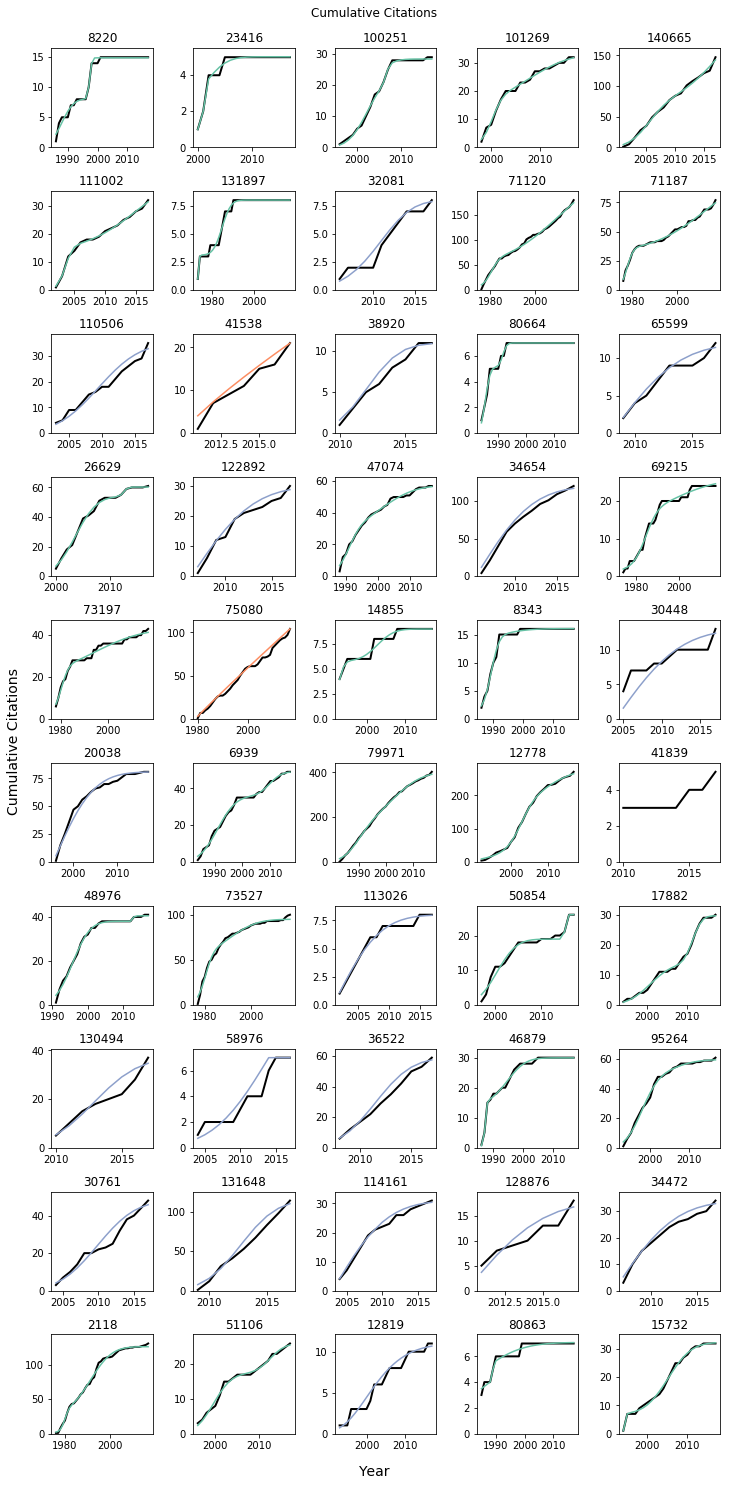

In [126]:

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2))
axes = axes.flatten()
for i, ind in enumerate(random_inds):
    axis = axes[i]
    
    axis.plot(years[ind][1:], cumulative_citations[ind], color='black', linewidth=2)
    maxy = max(cumulative_citations[ind])
    size = len(citations[ind])
    axis.set_ylim(0, maxy*1.1)
    axis.set_title(str(ind))
    
    try:
        params_ = params[i]
        best_fit = max(params_.items(), key=lambda kv: kv[1]['rsqrd'] if 'rsqrd' in kv[1] else 0)
        distname = best_fit[0]
        best_params = best_fit[1]['params']
    except KeyError:
         continue

    if distname == '2-gaussians':
        axis.plot(years[ind][1:], double_gaussian(years[ind][1:], *best_params),
                  color=colors[distname])
    elif distname == 'powerlaw':
        cdf_fitted = stats.powerlaw.cdf(years[ind][1:], *best_params[:-2],
                                        loc=best_params[-2], scale=best_params[-1])*size
        axis.plot(years[ind][1:], cdf_fitted,
                  color=colors[distname])
    elif distname == 'skewnorm':
        cdf_fitted = stats.skewnorm.cdf(years[ind][1:], *best_params[:-2],
                                        loc=best_params[-2], scale=best_params[-1])*size
        axis.plot(years[ind][1:], cdf_fitted,
                  color=colors[distname])

fig.suptitle('Cumulative Citations', y=1.01)

fig.text(0.5, -0.01, 'Year', ha='center', fontsize=14)
fig.text(-0.01, 0.5, 'Cumulative Citations', va='center', rotation='vertical', fontsize=14)

fig.tight_layout()
#fig.savefig('/Users/spardy/Desktop/cumulative_citations.pdf', dpi=300, bbox_inches='tight')


In [155]:
param

(14445359.301196963, 2008.9999983427651, 4.612964068572615)

## Save the fitting parameters

In [159]:
import multiprocess

In [157]:
parameters = []
for paper_citations in citations:
    size = len(paper_citations)
    a, loc, scale = dist.fit(paper_citations)
    parameters.append({'a': a, 'loc': loc, 'scale': scale})

/Users/spardy/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1612: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


KeyboardInterrupt: 

In [160]:
parameters

[{'a': -105831.93078715907,
  'loc': 2014.0002410584984,
  'scale': 6.1401893670710255},
 {'a': -554.56428039992898,
  'loc': 2015.0280468613018,
  'scale': 5.7025861994756539},
 {'a': -551621.12788155023,
  'loc': 2009.0000332565232,
  'scale': 3.9823697698643343},
 {'a': -3.7719269495250654,
  'loc': 2011.2982376901869,
  'scale': 4.8914792625754888},
 {'a': 8203130.5841140319,
  'loc': 2000.9999973338199,
  'scale': 4.3589383118075169},
 {'a': 0.000239735465342864,
  'loc': 2009.3170490759044,
  'scale': 4.9274370436964592},
 {'a': -419.12460439411825,
  'loc': 2017.054677142125,
  'scale': 9.1469058223477546},
 {'a': -3.5202786714769068,
  'loc': 2016.2422862872627,
  'scale': 7.4636553615064294},
 {'a': -4471.4733269034405,
  'loc': 2017.0066092522611,
  'scale': 8.6245277160400562},
 {'a': 9.7896514530872807,
  'loc': 2001.5583469404974,
  'scale': 6.1889131493754022},
 {'a': -4.2266063533533007,
  'loc': 2015.8194486243087,
  'scale': 7.0744907047045746},
 {'a': 19.9604839720850

In [163]:
params = pd.DataFrame(parameters)

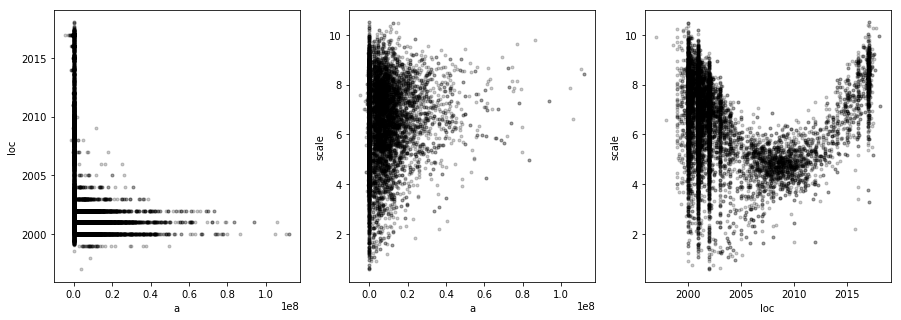

In [169]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axis = axes[0]
axis.plot(params['a'], params['loc'], 'k.', alpha=0.2)
axis.set_xlabel('a')
axis.set_ylabel('loc')

axis = axes[1]
axis.plot(params['a'], params['scale'], 'k.', alpha=0.2)
axis.set_xlabel('a')
axis.set_ylabel('scale')

axis = axes[2]
axis.plot(params['loc'], params['scale'], 'k.', alpha=0.2)
axis.set_xlabel('loc')
axis.set_ylabel('scale')
